# XGBoost

## Import libraries

In [271]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Files
from util import fetchOnlineData, create_dataset
from indicators import get_indicators

# TA Library (https://github.com/bukosabino/ta)
from ta import *

sns.set(font_scale = 1.5)

## Initial variables

In [272]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(1000)

## Import dataset

In [273]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday, del_cols=True)

[*********************100%***********************]  1 of 1 downloaded


# k-fold Cross Validation using XGBoost

In [278]:
# Create dataset
dataset = portf_value.copy()
dataset['date'] = portf_value.index
dataset.set_index('date', inplace=True)
dataset.rename(columns={'Adj Close': symbol}, inplace=True)

## Compute the Predictor variables

In [ ]:
# Get indicators
sym_mom, sma, q, rsi_value, rm = get_indicators(dataset, symbol)


# Compute momentum column
dataset['Momentum'] = sym_mom

# compute RSI column
dataset['RSI'] = rsi_value

# Clean nan values
dataset = dataset.fillna(0)

# Sort dataframe by index
dataset.sort_index()

## Scale data for using reg:logistic
If we want use objective = reg: if we want use objective = reg:logistic logistic regression, the label needed to be pre-scaled into [0,1]. logistic regression, the label needed to be pre-scaled into [0,1].

In [191]:
# Scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
np_scaled = scaler.fit_transform(dataset)
dataset_normalized = pd.DataFrame(np_scaled)
dataset_normalized

,0,1,2
0,0.055155,0.473759,0.398004
1,0.057700,0.473759,0.398004
2,0.030335,0.473759,0.398004
3,0.040942,0.473759,0.398004
4,0.029274,0.473759,0.398004
5,0.039245,0.473759,0.398004
6,0.032032,0.473759,0.398004
7,0.037123,0.473759,0.444489
8,0.045184,0.473759,0.515752
9,0.034154,0.473759,0.416779


## Setup the Target variable or the desired output.

In [192]:
X, y = dataset_normalized.iloc[:,:-1], dataset_normalized.iloc[:,-1]

## Create XGBoost DMatrix structure

In [193]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
print(data_dmatrix.get_label())

## Optimize parameters

In [195]:
print("Parameter optimization")

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200],
                    'learning_rate': [0.01, 0.1, 0.5],
                    'min_samples_split':range(200,1001,2000)}, verbose=1)
clf.fit(X,y)
print('Best Score: ', clf.best_score_)
print('Best params: ', clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Score:  0.5961231602913862
Best params:  {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 200, 'n_estimators': 50}


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    4.6s finished


## Create a hyper-parameter dictionary

We will create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs but will exclude the n_estimators from the hyper-parameter dictionary because you will use num_boost_rounds instead.

In [231]:
params = {'silent':1,
          "objective":"reg:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 4,
          'alpha': 10,
          'min_samples_split': 200,
          'n_estimators': 50}

We will use these parameters to build a x-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. Note that here you are using the Dmatrix object you created before.

In [269]:
cv_results = xgb.cv(verbose_eval=False,
                    dtrain=data_dmatrix, 
                    params=params, 
                    nfold=10,
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=123,)

## cv_results contains train and test RMSE metrics for each boosting round.

In [265]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.198488,0.002128,0.197806,0.019189
1,0.196911,0.002940,0.196438,0.019824
2,0.190701,0.004546,0.190387,0.020284
3,0.186590,0.006507,0.186493,0.020268
4,0.183958,0.007047,0.183970,0.020708


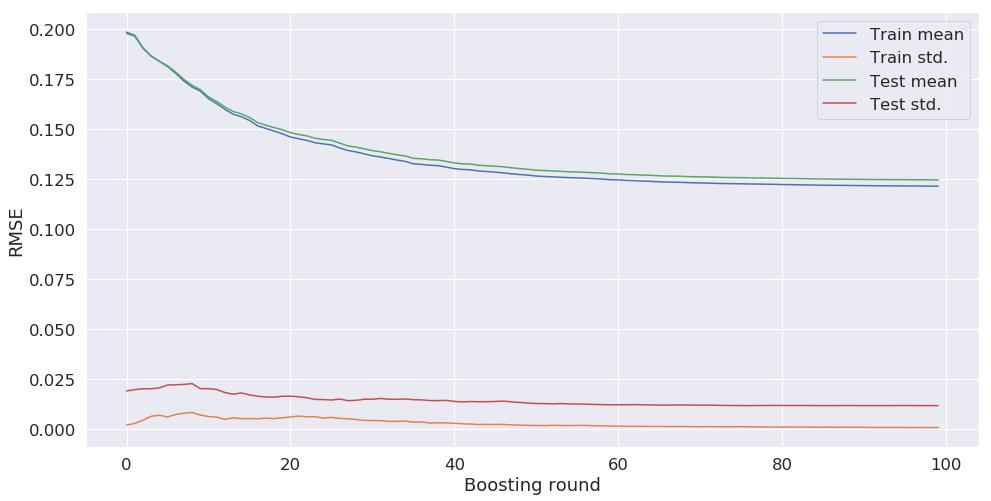

In [270]:
plt.figure(figsize=(16,8))
plt.plot(cv_results)
plt.xlabel('Boosting round')
plt.ylabel("RMSE")
plt.legend(["Train mean", "Train std.", "Test mean", "Test std."])
plt.show()

## Extract and print the final boosting round metric.

In [245]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.129944
Name: test-rmse-mean, dtype: float64


You can see that your RMSE for the price prediction has reduced as compared to last time and came out to be lower. 

You can reach an even lower RMSE for a different set of hyper-parameters. You may consider applying techniques like Grid Search, Random Search and Bayesian Optimization to reach the optimal set of hyper-parameters. 

## Instantiate an XGBoost regressor object

In [246]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

## Plotting the first tree

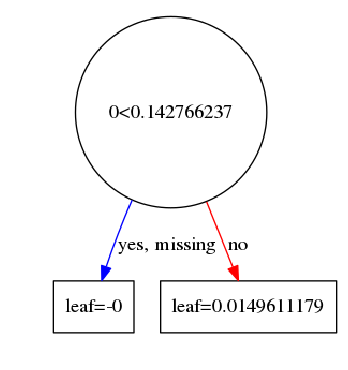

In [247]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

## Visualize your XGBoost models

It's to examine the importance of each feature column in the original dataset within the model.

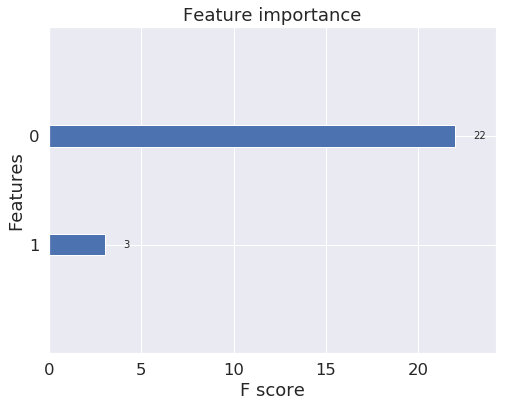

In [248]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [18, 6]
plt.show()

## Instantiate an XGBoost regressor object

## Split the data

In [249]:
# Define X and y
feature_cols = ['Momentum', 'RSI']
X = dataset[feature_cols]
y = dataset[symbol]

In [250]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

## Scale data for using reg:logistic
If we want use objective = reg: if we want use objective = reg:logistic logistic regression, the label needed to be pre-scaled into [0,1]. logistic regression, the label needed to be pre-scaled into [0,1].

In [251]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1, 1))

In [252]:
xg_reg = xgb.XGBRegressor(**params)

## Fit the regressor to the training set

In [262]:
xg_reg.fit(X_train_scaled,y_train_scaled, eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],)

[0]	validation_0-rmse:0.305839	validation_1-rmse:0.247858
[1]	validation_0-rmse:0.30177	validation_1-rmse:0.250258
[2]	validation_0-rmse:0.298327	validation_1-rmse:0.252821
[3]	validation_0-rmse:0.295086	validation_1-rmse:0.255333
[4]	validation_0-rmse:0.292567	validation_1-rmse:0.258021
[5]	validation_0-rmse:0.290384	validation_1-rmse:0.260285
[6]	validation_0-rmse:0.288328	validation_1-rmse:0.262502
[7]	validation_0-rmse:0.286517	validation_1-rmse:0.264813
[8]	validation_0-rmse:0.2849	validation_1-rmse:0.265009
[9]	validation_0-rmse:0.283598	validation_1-rmse:0.267227
[10]	validation_0-rmse:0.282524	validation_1-rmse:0.269101
[11]	validation_0-rmse:0.281249	validation_1-rmse:0.269471
[12]	validation_0-rmse:0.279918	validation_1-rmse:0.269084
[13]	validation_0-rmse:0.278722	validation_1-rmse:0.269289
[14]	validation_0-rmse:0.277764	validation_1-rmse:0.271148
[15]	validation_0-rmse:0.276816	validation_1-rmse:0.270978
[16]	validation_0-rmse:0.275955	validation_1-rmse:0.272685
[17]	valid

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, min_samples_split=200,
       missing=None, n_estimators=50, n_jobs=1, nthread=None,
       objective='reg:logistic', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=1, subsample=1)

## Make predictions on the test set

In [254]:
preds = xg_reg.predict(X_test_scaled)

## Compute the rmse

In [255]:
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.287793


## Plotting

### Standarize data 

In [256]:
preds = scaler.inverse_transform([preds])


In [257]:
# Convert array to series
mylist = preds.tolist()
se = pd.Series(mylist)


In [258]:
# Create a dataframe for plotting
predictions = pd.DataFrame()
predictions['Price'] = y_test
predictions['Forecast'] = se[0]


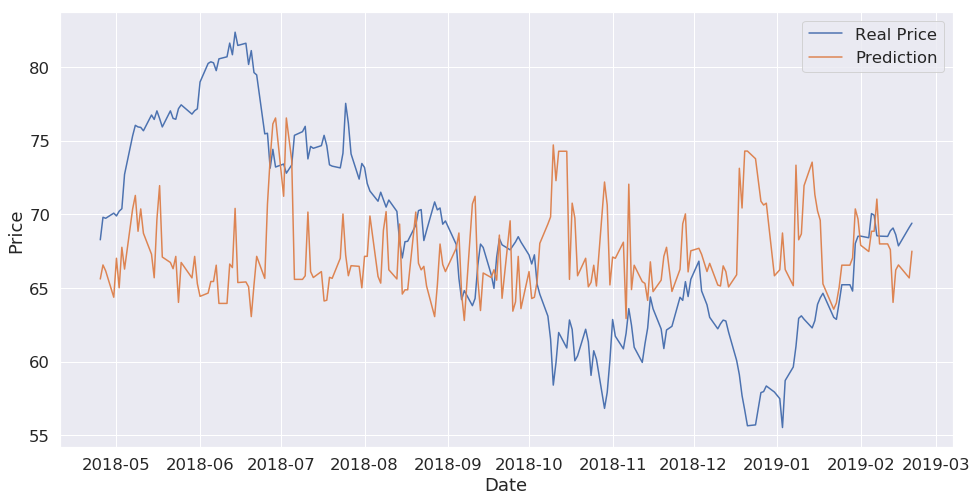

In [259]:
plt.figure(figsize=(16,8))
plt.plot(predictions)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()

# Save model

In [342]:
# save model to file
#joblib.dump(model, "./xgboost.dat")
# The sklearn API models are picklable
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(xg_reg, open("./xgboost.pkl", "wb"))

Pickling sklearn API models


# Compute indicators from TA library

## Import dataset

In [312]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday, del_cols=False)

[*********************100%***********************]  1 of 1 downloaded


In [313]:
df = add_all_ta_features(portf_value, "Open", "High", "Low", "Close", "Volume", fillna=True)

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning:

invalid value encountered in double_scalars

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ta/trend.py:634: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ta/trend.py:656: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



## Delete not indicators columns

In [314]:
df.reset_index(inplace=True)
del df['Date']
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Volume']

In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 60 columns):
Adj Close                  687 non-null float64
volume_adi                 687 non-null float64
volume_obv                 687 non-null int64
volume_obvm                687 non-null float64
volume_cmf                 687 non-null float64
volume_fi                  687 non-null float64
volume_em                  687 non-null float64
volume_vpt                 687 non-null float64
volume_nvi                 687 non-null float64
volatility_atr             687 non-null float64
volatility_bbh             687 non-null float64
volatility_bbl             687 non-null float64
volatility_bbm             687 non-null float64
volatility_bbhi            687 non-null float64
volatility_bbli            687 non-null float64
volatility_kcc             687 non-null float64
volatility_kch             687 non-null float64
volatility_kcl             687 non-null float64
volatility_kchi            687 no

## Correlation matrix

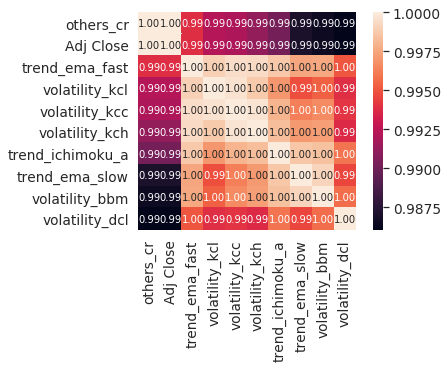

In [317]:
# Adj Close correlation matrix
corrmat = df.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Adj Close')['Adj Close'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()